In [1]:
using Gen
using Distributions
using Random
using Plots
using Statistics
using GenParticleFilters

# Model

In [2]:
# Some constants
const dt = 0.1         # Simulation fidelty
const LANDMARK_X = 3.0 # Landmark position
const LANDMARK_Y = 3.0
const LANDMARK1_X = LANDMARK_X  # Alias: landmark1
const LANDMARK1_Y = LANDMARK_Y
const LANDMARK2_X = -3.0          # landmark2 position
const LANDMARK2_Y = -3.0


-3.0

In [3]:
@gen function robot_localization_model(
    dt:Float64,
    controls::Matrix{Float64},
    T::Int,                    
    sigma_v::Float64,          
    sigma_omega::Float64,       
    sigma_obs::Float64         
)
    # Initial pose
    x = @trace(normal(0.0, 10.0), :x0)
    y = @trace(normal(0.0, 10.0), :y0)
    theta = @trace(normal(0.0, 3.0), :theta0)

    # Range to landmark 1
    range0 = sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2)
    @trace(normal(range0, sigma_obs), (:obs, 0))

    # Range to landmark 2
    range0_2 = sqrt((LANDMARK2_X - x)^2 + (LANDMARK2_Y - y)^2)
    @trace(normal(range0_2, sigma_obs), (:obs2, 0))

    for t in 1:T        
        # Odometry readings will be noisy. We add a simplified noise model that adds some gaussian noise
        v_noisy = @trace(normal(controls[t, 1], sigma_v), (:v_noise, t))
        omega_noisy = @trace(normal(controls[t, 2], sigma_omega), (:omega_noise, t))

        # Update the pose and range to landmakr
        theta = rem2pi(theta + omega_noisy * dt, RoundNearest)
        x = x + v_noisy * cos(theta) * dt
        y = y + v_noisy * sin(theta) * dt

        expected_range = sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2)
        @trace(normal(expected_range, sigma_obs), (:obs, t))

        expected_range2 = sqrt((LANDMARK2_X - x)^2 + (LANDMARK2_Y - y)^2)
        @trace(normal(expected_range2, sigma_obs), (:obs2, t))
    end

    return (x, y, theta)
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Matrix{Float64}, Int64, Float64, Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing], Main.var"##robot_localization_model#277", Bool[0, 0, 0, 0, 0, 0], false)

In [23]:
# Example impulse control generation. In a real-world setting we would first collect this data from the robot
# controls and then read it into the program rather than simulate it.
Random.seed!(421)

T = 100
sigma_v = 0.05
sigma_omega = 0.03
sigma_obs = 0.3
controls = zeros(T, 2)
turn_bias = 0.0

for t in 1:T
    # Occasionally change turn direction
    if t % 7 == 1 || rand() < 0.15
        turn_bias = randn() * 1.5
    end
    v = 0.35 + 0.1 * randn()
    omega = turn_bias + 0.8 * randn()
    controls[t, 1] = clamp(v, 0.2, 0.5)
    controls[t, 2] = clamp(omega, -2.0, 2.0)
end

In [24]:
# Generate a trace from the model
(trace, _) = generate(robot_localization_model, (dt, controls, T, sigma_v, sigma_omega, sigma_obs))

# Extract ground truth initial state
x0_true = trace[:x0]
y0_true = trace[:y0]
theta0_true = trace[:theta0]

# Extract observations
observations  = [trace[(:obs, t)]  for t in 0:T]   # landmark 1
observations2 = [trace[(:obs2, t)] for t in 0:T]   # landmark 2

println("Initial pose")
println("x0 = $(round(x0_true, digits=3))")
println("y0 = $(round(y0_true, digits=3))")
println("θ0 = $(round(theta0_true, digits=3)) rad")

println("\nObservations (range to landmarks)")
for t in 0:50:T
    println("t=$t: r1=$(round(observations[t+1], digits=2)) m, r2=$(round(observations2[t+1], digits=2)) m")
end


Initial pose
x0 = -9.512
y0 = -0.26
θ0 = -3.628 rad

Observations (range to landmarks)
t=0: r1=13.09 m, r2=7.28 m
t=50: r1=12.02 m, r2=6.69 m
t=100: r1=13.71 m, r2=8.74 m


In [25]:
# A naive function to reconstruct trajectory from observations. This just
# uses noisy observations, accumulating error.
function simulate_trajectory(trace, controls, T)
    # List of estimated poses 
    poses = zeros(T+1, 3)
    
    # Initial pose
    x = trace[:x0]
    y = trace[:y0]
    theta = trace[:theta0]
    poses[1, :] = [x, y, theta]
    
    for t in 1:T
        theta = rem2pi(theta + trace[(:omega_noise, t)] * dt, RoundNearest)
        x = x + trace[(:v_noise, t)] * cos(theta) * dt
        y = y + trace[(:v_noise, t)] * sin(theta) * dt
        poses[t+1, :] = [x, y, theta]
    end
    
    return poses
end

simulate_trajectory (generic function with 1 method)

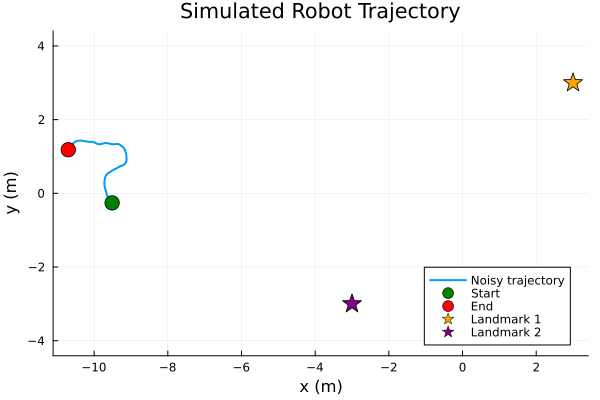

In [26]:
true_poses = simulate_trajectory(trace, controls, T)

# Plot the noisy trajectory
p = plot(
    true_poses[:, 1], true_poses[:, 2],
    label="Noisy trajectory",
    xlabel="x (m)", ylabel="y (m)",
    title="Simulated Robot Trajectory",
    linewidth=2,
    aspect_ratio=:equal,
    legend=:bottomright
)

# Mark start, end, and landmarks
scatter!(p, [true_poses[1, 1]], [true_poses[1, 2]], label="Start", markersize=8, color=:green)
scatter!(p, [true_poses[end, 1]], [true_poses[end, 2]], label="End", markersize=8, color=:red)
scatter!(p, [LANDMARK_X],  [LANDMARK_Y],  label="Landmark 1", markersize=10, markershape=:star5, color=:orange)
scatter!(p, [LANDMARK2_X], [LANDMARK2_Y], label="Landmark 2", markersize=10, markershape=:star5, color=:purple)

display(p)


# Baselines

In [27]:
# Setup: Create observation constraints ONLY (no odometry noise - fair comparison)
# This means MH must also infer the noise path, same as Bootstrap PF
obs_constraints = choicemap()
for t in 0:T
    obs_constraints[(:obs, t)]  = observations[t+1]
    obs_constraints[(:obs2, t)] = observations2[t+1]
end

println("Ground truth initial pose:")
println("x0 = ", round(x0_true, digits=3))
println("y0 = ", round(y0_true, digits=3))
println("θ0 = ", round(theta0_true, digits=3))


Ground truth initial pose:
x0 = -9.512
y0 = -0.26
θ0 = -3.628


# MH Baseline

In [28]:
# Metropolis-Hastings with BLOCKED UPDATES (fair - also updates noise path)
# Must update both pose AND noise variables since noise is not constrained
Random.seed!(420)

(current_trace, _) = generate(robot_localization_model, (dt, controls, T, sigma_v, sigma_omega, sigma_obs), obs_constraints)

# Selection for pose parameters
pose_sel = select(:x0, :y0, :theta0)

# Function to create selection for a subset of noise timesteps
function noise_sel(ts)
    addrs = Any[]
    for t in ts
        push!(addrs, (:v_noise, t))
        push!(addrs, (:omega_noise, t))
    end
    return select(addrs...)
end

num_mh_iterations = 100
mh_samples_x0 = Float64[]
mh_samples_y0 = Float64[]
mh_samples_theta0 = Float64[]
pose_accepted = 0
noise_accepted = 0

for i in 1:num_mh_iterations
    # Update pose
    (current_trace, acc_pose) = mh(current_trace, pose_sel)
    pose_accepted += acc_pose
    
    # Update ALL noise variables at once
    (current_trace, acc_noise) = mh(current_trace, noise_sel(1:T))
    noise_accepted += acc_noise
    
    push!(mh_samples_x0, current_trace[:x0])
    push!(mh_samples_y0, current_trace[:y0])
    push!(mh_samples_theta0, current_trace[:theta0])
    
    if i % 20 == 0
        println("MH Iteration $i: x0=$(round(current_trace[:x0], digits=3)), y0=$(round(current_trace[:y0], digits=3)), θ0=$(round(current_trace[:theta0], digits=3))")
    end
end

println("\nMH Results (blocked updates, fair comparison):")
println("Pose acceptance: $(round(pose_accepted/num_mh_iterations*100, digits=1))%")
println("Noise acceptance: $(round(noise_accepted/num_mh_iterations*100, digits=1))%")
println("x0: mean=$(round(mean(mh_samples_x0), digits=3)), true=$(round(x0_true, digits=3))")
println("y0: mean=$(round(mean(mh_samples_y0), digits=3)), true=$(round(y0_true, digits=3))")
println("θ0: mean=$(round(mean(mh_samples_theta0), digits=3)), true=$(round(theta0_true, digits=3))")

MH Iteration 20: x0=-6.711, y0=-7.833, θ0=0.195
MH Iteration 40: x0=-6.649, y0=-5.704, θ0=-1.609
MH Iteration 60: x0=-6.649, y0=-5.704, θ0=-1.609
MH Iteration 80: x0=-8.675, y0=-4.194, θ0=-2.233
MH Iteration 100: x0=-11.358, y0=0.43, θ0=-0.116

MH Results (blocked updates, fair comparison):
Pose acceptance: 6.0%
Noise acceptance: 12.0%
x0: mean=-6.496, true=-9.512
y0: mean=-5.452, true=-0.26
θ0: mean=-1.578, true=-3.628


# Particle Filter Baseline

In [29]:
# Simple importance sampling with resampling
Random.seed!(420)
n_particles = 200

obs_cm = choicemap()
for t in 0:T
    obs_cm[(:obs, t)]  = observations[t+1]
    obs_cm[(:obs2, t)] = observations2[t+1]
end

particles = Vector{Any}(undef, n_particles)
log_weights = zeros(n_particles)

for i in 1:n_particles
    (particles[i], log_weights[i]) = generate(robot_localization_model, 
        (dt, controls, T, sigma_v, sigma_omega, sigma_obs), obs_cm)
end

log_total = logsumexp(log_weights)
weights = exp.(log_weights .- log_total)
indices = rand(Categorical(weights), n_particles)
particles = particles[indices]

pf_x0 = [p[:x0] for p in particles]
pf_y0 = [p[:y0] for p in particles]
pf_theta0 = [p[:theta0] for p in particles]

x0_pf = mean(pf_x0)
y0_pf = mean(pf_y0)
theta0_pf = mean(pf_theta0)

println("Particle Filter Results:")
println("x0: mean=$(round(x0_pf, digits=3)), true=$(round(x0_true, digits=3))")
println("y0: mean=$(round(y0_pf, digits=3)), true=$(round(y0_true, digits=3))")
println("θ0: mean=$(round(theta0_pf, digits=3)), true=$(round(theta0_true, digits=3))")


Particle Filter Results:
x0: mean=-10.945, true=-9.512
y0: mean=0.078, true=-0.26
θ0: mean=1.89, true=-3.628


In [30]:
Random.seed!(422)

Np   = 300
ESSr = 0.5     # resample if ESS < ESSr*Np
Nbw  = 25     # backward trajectories
n_mcmc = 5     # MCMC rejuvenation steps after resampling
σ_x_prop = 0.1 # proposal std for x, y
σ_th_prop = 0.05 # proposal std for θ

# --- small helpers ---
wrap_pi(δ) = mod(δ + π, 2π) - π

function logsumexp(v::AbstractVector{<:Real})
    m = maximum(v)
    isfinite(m) || return m
    return m + log(sum(exp.(v .- m)))
end

function systematic_resample(w::AbstractVector{<:Real})
    N = length(w)
    u0 = rand() / N
    cs = cumsum(w)
    idx = Vector{Int}(undef, N)
    j = 1
    for i in 1:N
        u = u0 + (i-1)/N
        while u > cs[j]; j += 1; end
        idx[i] = j
    end
    return idx
end

range_loglik(x,y,z) =
    Distributions.logpdf(Distributions.Normal(hypot(LANDMARK_X - x, LANDMARK_Y - y), sigma_obs), z)

range2_loglik(x,y,z) =
    Distributions.logpdf(Distributions.Normal(hypot(LANDMARK2_X - x, LANDMARK2_Y - y), sigma_obs), z)

function transition_logp(x_t,y_t,th_t, x_n,y_n,th_n, t)
    ω = wrap_pi(th_n - th_t) / dt
    # Project displacement onto heading direction (model uses updated heading)
    v = ((x_n - x_t)*cos(th_n) + (y_n - y_t)*sin(th_n)) / dt
    return Distributions.logpdf(Distributions.Normal(controls[t,1], sigma_v), v) +
           Distributions.logpdf(Distributions.Normal(controls[t,2], sigma_omega), ω)
end

normw(lw) = exp.(lw .- logsumexp(lw))

# --- storage (t=0..T => indices 1..T+1) ---
Xs = Vector{Vector{Float64}}(undef, T+1)
Ys = Vector{Vector{Float64}}(undef, T+1)
Th = Vector{Vector{Float64}}(undef, T+1)
Ws = Vector{Vector{Float64}}(undef, T+1)

# --- forward filter with MCMC rejuvenation ---
# Initialize from TRUE model prior: x0,y0 ~ N(0,10), θ0 ~ N(0,3)
x  = randn(Np) .* 10.0
y  = randn(Np) .* 10.0
th = randn(Np) .* 3.0
lw = [range_loglik(x[i], y[i], observations[1]) + range2_loglik(x[i], y[i], observations2[1]) for i in 1:Np]

Xs[1], Ys[1], Th[1] = copy(x), copy(y), copy(th)
Ws[1] = normw(lw)

n_resamples = 0
total_accepts = 0
total_mcmc = 0

for t in 1:T
    w = normw(lw)
    ess = 1 / sum(w.^2)
    if ess < ESSr * Np
        idx = systematic_resample(w)
        x, y, th = x[idx], y[idx], th[idx]
        lw .= 0.0
        n_resamples += 1

        # MCMC rejuvenation: run MH moves on each particle
        # Target: p(s_t | z_{0:t}) ∝ p(s_t) * ∏_{τ=0}^{t} p(z_τ | s_τ)
        # But we only have current state, so we target p(s | z_t) approximately
        for m in 1:n_mcmc
            for i in 1:Np
                # Propose perturbation
                x_prop = x[i] + σ_x_prop * randn()
                y_prop = y[i] + σ_x_prop * randn()
                th_prop = rem2pi(th[i] + σ_th_prop * randn(), RoundNearest)

                # Current and proposed log-likelihoods (using most recent observation)
                ll_curr = range_loglik(x[i], y[i], observations[t]) + range2_loglik(x[i], y[i], observations2[t])
                ll_prop = range_loglik(x_prop, y_prop, observations[t]) + range2_loglik(x_prop, y_prop, observations2[t])

                # Accept/reject (symmetric proposal, so just likelihood ratio)
                if log(rand()) < ll_prop - ll_curr
                    x[i], y[i], th[i] = x_prop, y_prop, th_prop
                    total_accepts += 1
                end
                total_mcmc += 1
            end
        end
    end

    for i in 1:Np
        v = rand(Normal(controls[t,1], sigma_v))
        ω = rand(Normal(controls[t,2], sigma_omega))

        th[i] = rem2pi(th[i] + ω*dt, RoundNearest)
        x[i] += v*cos(th[i])*dt
        y[i] += v*sin(th[i])*dt

        lw[i] += range_loglik(x[i], y[i], observations[t+1]) + range2_loglik(x[i], y[i], observations2[t+1])
    end

    Xs[t+1], Ys[t+1], Th[t+1] = copy(x), copy(y), copy(th)
    Ws[t+1] = normw(lw)
end

println("Forward PF: $n_resamples resamples, MCMC accept rate: $(round(100*total_accepts/max(1,total_mcmc), digits=1))%")

# --- backward simulation ---
x0s = Vector{Float64}(undef, Nbw)
y0s = Vector{Float64}(undef, Nbw)
t0s = Vector{Float64}(undef, Nbw)

for b in 1:Nbw
    j = rand(Categorical(Ws[T+1]))
    xc, yc, thc = Xs[T+1][j], Ys[T+1][j], Th[T+1][j]

    for t in T:-1:1
        logbw = Vector{Float64}(undef, Np)
        for i in 1:Np
            logbw[i] = log(Ws[t][i] + 1e-300) +
                       transition_logp(Xs[t][i], Ys[t][i], Th[t][i], xc, yc, thc, t)
        end
        bw = exp.(logbw .- logsumexp(logbw))
        j = rand(Categorical(bw))
        xc, yc, thc = Xs[t][j], Ys[t][j], Th[t][j]
    end

    x0s[b], y0s[b], t0s[b] = xc, yc, thc
end

x0_hat, y0_hat, th0_hat = mean(x0s), mean(y0s), mean(t0s)
println("FFBSi x0=$(round(x0_hat,digits=3)), y0=$(round(y0_hat,digits=3)), θ0=$(round(th0_hat,digits=3))")
println("stds:  x0=$(round(std(x0s),digits=3)), y0=$(round(std(y0s),digits=3)), θ0=$(round(std(t0s),digits=3))")


Forward PF: 40 resamples, MCMC accept rate: 83.0%
FFBSi x0=0.536, y0=-8.555, θ0=-2.434
stds:  x0=0.364, y0=3.12, θ0=1.294


# Comparison

In [31]:
# Summary comparison - ALL methods estimate INITIAL POSE (smoothing)
println("=" ^ 70)
println("INFERENCE RESULTS COMPARISON - SMOOTHING")
println("All methods estimate p(x0, y0, θ0 | z_{0:T})")
println("=" ^ 70)

println("\nGround Truth: x0=$(round(x0_true, digits=3)), y0=$(round(y0_true, digits=3)), θ0=$(round(theta0_true, digits=3))")

println("\n1. MH (blocked updates):")
mh_x0 = mean(mh_samples_x0)
mh_y0 = mean(mh_samples_y0)
mh_theta0 = mean(mh_samples_theta0)
mh_err = sqrt((mh_x0-x0_true)^2 + (mh_y0-y0_true)^2 + (mh_theta0-theta0_true)^2)
println("  Estimate: x0=$(round(mh_x0, digits=3)), y0=$(round(mh_y0, digits=3)), θ0=$(round(mh_theta0, digits=3))")
println("  Std: x0=$(round(std(mh_samples_x0), digits=3)), y0=$(round(std(mh_samples_y0), digits=3)), θ0=$(round(std(mh_samples_theta0), digits=3))")
println("  RMSE: $(round(mh_err, digits=3))")

println("\n2. IS (importance sampling with resampling):")
is_err = sqrt((x0_pf-x0_true)^2 + (y0_pf-y0_true)^2 + (theta0_pf-theta0_true)^2)
println("  Estimate: x0=$(round(x0_pf, digits=3)), y0=$(round(y0_pf, digits=3)), θ0=$(round(theta0_pf, digits=3))")
println("  Std: x0=$(round(std(pf_x0), digits=3)), y0=$(round(std(pf_y0), digits=3)), θ0=$(round(std(pf_theta0), digits=3))")
println("  RMSE: $(round(is_err, digits=3))")

println("\n3. FFBSi Particle Smoother (backward simulation):")
ps_err = sqrt((x0_hat-x0_true)^2 + (y0_hat-y0_true)^2 + (th0_hat-theta0_true)^2)
println("  Estimate: x0=$(round(x0_hat, digits=3)), y0=$(round(y0_hat, digits=3)), θ0=$(round(th0_hat, digits=3))")
println("  Std: x0=$(round(std(x0s), digits=3)), y0=$(round(std(y0s), digits=3)), θ0=$(round(std(t0s), digits=3))")
println("  RMSE: $(round(ps_err, digits=3))")

println("\n" * "=" ^ 70)
errors = [("MH", mh_err), ("IS", is_err), ("FFBSi", ps_err)]
sort!(errors, by=x->x[2])
println("Ranking (best to worst):")
for (i, (name, err)) in enumerate(errors)
    println("  $i. $name: RMSE = $(round(err, digits=3))")
end
println("=" ^ 70)

INFERENCE RESULTS COMPARISON - SMOOTHING
All methods estimate p(x0, y0, θ0 | z_{0:T})

Ground Truth: x0=-9.512, y0=-0.26, θ0=-3.628

1. MH (blocked updates):
  Estimate: x0=-6.496, y0=-5.452, θ0=-1.578
  Std: x0=3.098, y0=1.376, θ0=1.132
  RMSE: 6.345

2. IS (importance sampling with resampling):
  Estimate: x0=-10.945, y0=0.078, θ0=1.89
  Std: x0=0.0, y0=0.0, θ0=0.0
  RMSE: 5.71

3. FFBSi Particle Smoother (backward simulation):
  Estimate: x0=0.536, y0=-8.555, θ0=-2.434
  Std: x0=0.364, y0=3.12, θ0=1.294
  RMSE: 13.084

Ranking (best to worst):
  1. IS: RMSE = 5.71
  2. MH: RMSE = 6.345
  3. FFBSi: RMSE = 13.084
